
#  Intrusion Detection System (IDS) with XGBoost — NSL-KDD

**Team 11: AI for Cybersecurity** — *Model Engineer Notebook*

This notebook builds an Intrusion Detection System (IDS) using the **NSL-KDD** dataset and the **XGBoost** algorithm, following an industry-standard ML workflow.

## Objectives
- Load and explore the NSL-KDD dataset
- Preprocess data (encoding, scaling, train/test split, SMOTE)
- Train baseline and XGBoost models
- Evaluate with classification metrics & confusion matrix
- Explain predictions with **SHAP**
- Discuss ethics and limitations
- Export the trained model for reuse



## 1. Environment Setup

> Run this cell to install required libraries if missing (e.g., in Colab). If you already have them, you can skip.


In [1]:

# If running on a fresh environment (e.g., Colab), uncomment to install:
%pip install -q xgboost scikit-learn pandas numpy shap imbalanced-learn kagglehub matplotlib


Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 25.1.1 -> 25.2
[notice] To update, run: C:\Users\user\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip



## 2. Imports & Configuration


In [1]:

import os
import sys
import json
from pathlib import Path

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.metrics import (classification_report, confusion_matrix, 
                             f1_score, precision_score, recall_score, accuracy_score)

from sklearn.ensemble import RandomForestClassifier

from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImbPipeline

from xgboost import XGBClassifier

import shap
import joblib

# Matplotlib settings
plt.rcParams['figure.figsize'] = (8, 5)
plt.rcParams['axes.grid'] = True


C:\Users\user\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm



## 3. Data Loading & Exploration

This section attempts to locate NSL-KDD files automatically. **You have two options**:

- **Option A (Recommended):** Use `kagglehub` to download the dataset programmatically.
- **Option B:** Manually place the files locally (e.g., `./data/`) and set `DATA_DIR` accordingly.

**Common NSL-KDD file names:**
- `KDDTrain+.csv` or `KDDTrain+.txt`
- `KDDTest+.csv` or `KDDTest+.txt`

> The notebook is robust to either `.csv` or `.txt` delimiters.


In [2]:

# Locate or download dataset
DATA_DIR = os.environ.get("DATA_DIR", "./data")
DATA_DIR = Path(DATA_DIR)
DATA_DIR.mkdir(parents=True, exist_ok=True)

train_candidates = [
    DATA_DIR / "KDDTrain+.csv", DATA_DIR / "KDDTrain+.txt",
    DATA_DIR / "KDDTrain.csv",  DATA_DIR / "KDDTrain.txt"
]
test_candidates = [
    DATA_DIR / "KDDTest+.csv", DATA_DIR / "KDDTest+.txt",
    DATA_DIR / "KDDTest.csv",  DATA_DIR / "KDDTest.txt"
]

# Try kagglehub if files missing
if not any(p.exists() for p in train_candidates+test_candidates):
    try:
        import kagglehub
        path = Path(kagglehub.dataset_download("hassan06/nslkdd"))
        # Move files into DATA_DIR if needed
        for p in path.iterdir():
            if p.is_file():
                dest = DATA_DIR / p.name
                if not dest.exists():
                    dest.write_bytes(p.read_bytes())
        print("Downloaded with kagglehub to:", DATA_DIR.resolve())
    except Exception as e:
        print("kagglehub download failed or not available:", e)
        print("Please place NSL-KDD files into", DATA_DIR.resolve())

def load_nsl_kdd(train_path, test_path):
    # Try to infer delimiter
    def read_any(p):
        p = Path(p)
        if p.suffix.lower() == ".csv":
            return pd.read_csv(p)
        elif p.suffix.lower() == ".txt":
            # NSL-KDD txts are comma-separated
            return pd.read_csv(p, header=None)
        else:
            # Fallback
            return pd.read_csv(p)
    df_train = read_any(train_path)
    df_test  = read_any(test_path)
    return df_train, df_test

# Column names (NSL-KDD has 41 feature columns + 'label' + 'difficulty')
NSL_KDD_COLUMNS = [
    "duration","protocol_type","service","flag","src_bytes","dst_bytes","land","wrong_fragment","urgent",
    "hot","num_failed_logins","logged_in","num_compromised","root_shell","su_attempted","num_root",
    "num_file_creations","num_shells","num_access_files","num_outbound_cmds","is_host_login","is_guest_login",
    "count","srv_count","serror_rate","srv_serror_rate","rerror_rate","srv_rerror_rate","same_srv_rate",
    "diff_srv_rate","srv_diff_host_rate","dst_host_count","dst_host_srv_count","dst_host_same_srv_rate",
    "dst_host_diff_srv_rate","dst_host_same_src_port_rate","dst_host_srv_diff_host_rate",
    "dst_host_serror_rate","dst_host_srv_serror_rate","dst_host_rerror_rate","dst_host_srv_rerror_rate",
    "label","difficulty"
]

# Find actual files
def find_first_existing(cands):
    for p in cands:
        if Path(p).exists():
            return p
    return None

train_file = find_first_existing(train_candidates)
test_file  = find_first_existing(test_candidates)

if train_file is None or test_file is None:
    raise FileNotFoundError(
        f"NSL-KDD files not found in {DATA_DIR.resolve()}. "
        "Expected something like KDDTrain+.csv/.txt and KDDTest+.csv/.txt."
    )

df_train, df_test = load_nsl_kdd(train_file, test_file)

# If files had no headers, apply column names
if df_train.shape[1] == len(NSL_KDD_COLUMNS):
    df_train.columns = NSL_KDD_COLUMNS
if df_test.shape[1] == len(NSL_KDD_COLUMNS):
    df_test.columns = NSL_KDD_COLUMNS

print("Train shape:", df_train.shape, "| Test shape:", df_test.shape)
display(df_train.head())


100%|██████████| 13.9M/13.9M [00:13<00:00, 1.11MB/s]

Extracting files...


Downloaded with kagglehub to: C:\Users\user\OneDrive\Desktop\UG\L300\Sem-2\CPEN 316 (Artificial Intelligence and its Applications)\IDS-project\intrusion-detection-system\data
Train shape: (125973, 43) | Test shape: (22544, 43)


,duration,protocol_type,service,flag,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,...,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,label,difficulty
0,0,tcp,ftp_data,SF,491,0,0,0,0,0,...,0.17,0.03,0.17,0.00,0.00,0.00,0.05,0.00,normal,20
1,0,udp,other,SF,146,0,0,0,0,0,...,0.00,0.60,0.88,0.00,0.00,0.00,0.00,0.00,normal,15
2,0,tcp,private,S0,0,0,0,0,0,0,...,0.10,0.05,0.00,0.00,1.00,1.00,0.00,0.00,neptune,19
3,0,tcp,http,SF,232,8153,0,0,0,0,...,1.00,0.00,0.03,0.04,0.03,0.01,0.00,0.01,normal,21
4,0,tcp,http,SF,199,420,0,0,0,0,...,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,normal,21



### 3.1 Basic EDA
- Shapes, dtypes, missing values
- Class distribution (multi-class & binary)
- Quick feature correlation (numeric only)


duration               int64
protocol_type         object
service               object
flag                  object
src_bytes              int64
dst_bytes              int64
land                   int64
wrong_fragment         int64
urgent                 int64
hot                    int64
num_failed_logins      int64
logged_in              int64
num_compromised        int64
root_shell             int64
su_attempted           int64
num_root               int64
num_file_creations     int64
num_shells             int64
num_access_files       int64
num_outbound_cmds      int64
dtype: object


Missing values (train):
 0
Missing values (test): 0

Label distribution (train):
 label
normal             67343
neptune            41214
satan               3633
ipsweep             3599
portsweep           2931
smurf               2646
nmap                1493
back                 956
teardrop             892
warezclient          890
pod                  201
guess_passwd          53
buffer_overflow       30
warezmaster           20
land                  18
imap                  11
rootkit               10
loadmodule             9
ftp_write              8
multihop               7
phf                    4
perl                   3
spy                    2
Name: count, dtype: int64

Binary distribution (train):
 label
0    67343
1    58630
Name: count, dtype: int64


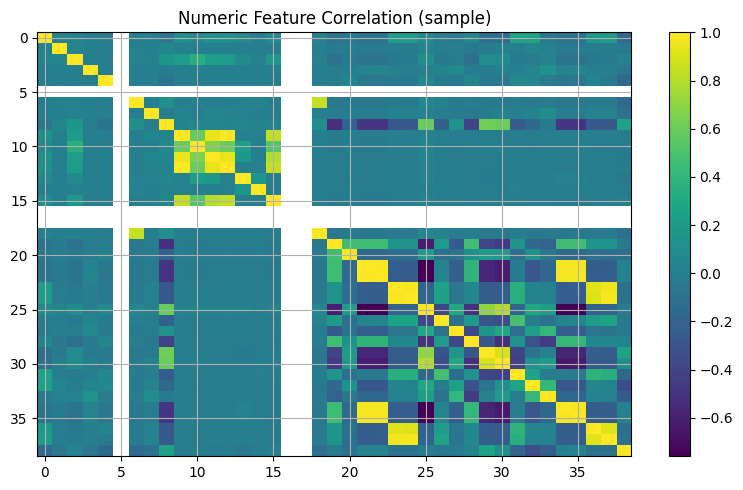

In [3]:

# Dtypes & missing
display(df_train.dtypes.head(20))
print("\nMissing values (train):\n", df_train.isna().sum().sum())
print("Missing values (test):", df_test.isna().sum().sum())

# Class distribution (multi-class)
print("\nLabel distribution (train):\n", df_train['label'].value_counts())

# Binary mapping for overview
def to_binary(y):
    return (y != 'normal').astype(int)

y_train_bin = to_binary(df_train['label'])
print("\nBinary distribution (train):\n", pd.Series(y_train_bin).value_counts())

# Quick numeric correlation (sample to speed up)
num_cols = df_train.select_dtypes(include=[np.number]).columns.tolist()
if len(num_cols) > 0:
    corr = df_train[num_cols].sample(min(len(df_train), 5000), random_state=42).corr()
    plt.figure()
    plt.imshow(corr, aspect='auto')
    plt.title("Numeric Feature Correlation (sample)")
    plt.colorbar()
    plt.tight_layout()
    plt.show()



## 4. Data Preprocessing

- Handle missing values (imputation)
- Encode categoricals (`protocol_type`, `service`, `flag`)
- Scale numericals
- Convert labels to binary (normal → 0, attacks → 1)
- **Important:** Apply **SMOTE on the training set only** to avoid leakage


In [4]:

# Separate features / labels
X_train_raw = df_train.drop(columns=['label', 'difficulty'], errors='ignore')
X_test_raw  = df_test.drop(columns=['label', 'difficulty'], errors='ignore')
y_train_mc  = df_train['label'].copy()
y_test_mc   = df_test['label'].copy()

# Binary labels
y_train = (y_train_mc != 'normal').astype(int)
y_test  = (y_test_mc  != 'normal').astype(int)

# Identify categorical / numerical columns
categorical_features = ['protocol_type', 'service', 'flag']
numerical_features = [c for c in X_train_raw.columns if c not in categorical_features]

# Preprocessors
numeric_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("onehot", OneHotEncoder(handle_unknown="ignore"))
])

preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, numerical_features),
        ("cat", categorical_transformer, categorical_features),
    ]
)

# Train/test split is already provided by NSL-KDD (KDDTrain+ vs KDDTest+)
# We will still reserve a validation split from the train set for tuning if needed.
X_tr, X_val, y_tr, y_val = train_test_split(
    X_train_raw, y_train, test_size=0.2, random_state=42, stratify=y_train
)

print("Train split:", X_tr.shape, "Val split:", X_val.shape)

# SMOTE only on the training portion
smote = SMOTE(random_state=42)


Train split: (100778, 41) Val split: (25195, 41)



## 5. Baseline Model (Random Forest)



Baseline on Validation Set:
=== Baseline (Val) ===
F1: 0.9991 | Precision: 0.9994 | Recall: 0.9987 | Accuracy: 0.9991 | FPR: 0.0005

Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00     13469
           1       1.00      1.00      1.00     11726

    accuracy                           1.00     25195
   macro avg       1.00      1.00      1.00     25195
weighted avg       1.00      1.00      1.00     25195



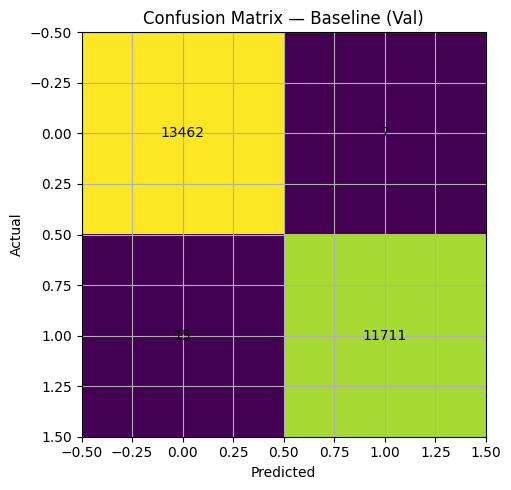

In [5]:

baseline_clf = RandomForestClassifier(
    n_estimators=200, random_state=42, n_jobs=-1
)

baseline_pipe = ImbPipeline(steps=[
    ("preprocess", preprocessor),
    ("smote", smote),
    ("clf", baseline_clf)
])

baseline_pipe.fit(X_tr, y_tr)

def evaluate_model(estimator, X, y, label="Eval"):
    y_pred = estimator.predict(X)
    y_proba = None
    try:
        y_proba = estimator.predict_proba(X)[:,1]
    except Exception:
        pass
    f1 = f1_score(y, y_pred)
    prec = precision_score(y, y_pred)
    rec = recall_score(y, y_pred)
    acc = accuracy_score(y, y_pred)
    tn, fp, fn, tp = confusion_matrix(y, y_pred).ravel()
    fpr = fp / (fp + tn)
    print(f"=== {label} ===")
    print(f"F1: {f1:.4f} | Precision: {prec:.4f} | Recall: {rec:.4f} | Accuracy: {acc:.4f} | FPR: {fpr:.4f}")
    print("\nClassification Report:\n", classification_report(y, y_pred))
    # Confusion matrix plot
    cm = np.array([[tn, fp],[fn, tp]])
    plt.figure()
    plt.imshow(cm, cmap=None)
    plt.title(f"Confusion Matrix — {label}")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    for (i, j), v in np.ndenumerate(cm):
        plt.text(j, i, int(v), ha='center', va='center')
    plt.tight_layout()
    plt.show()
    return {"f1": f1, "precision": prec, "recall": rec, "accuracy": acc, "fpr": fpr}

print("\nBaseline on Validation Set:")
baseline_val_metrics = evaluate_model(baseline_pipe, X_val, y_val, label="Baseline (Val)")



## 6. XGBoost Model — Training & Hyperparameter Tuning
We use the **scikit-learn wrapper** for smooth integration with pipelines and GridSearchCV.


Fitting 3 folds for each of 24 candidates, totalling 72 fits
Best Params: {'clf__colsample_bytree': 1.0, 'clf__learning_rate': 0.1, 'clf__max_depth': 6, 'clf__subsample': 1.0}

Validation Performance (Best XGB):
=== XGB (Val) ===
F1: 0.9992 | Precision: 0.9992 | Recall: 0.9992 | Accuracy: 0.9993 | FPR: 0.0007

Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00     13469
           1       1.00      1.00      1.00     11726

    accuracy                           1.00     25195
   macro avg       1.00      1.00      1.00     25195
weighted avg       1.00      1.00      1.00     25195



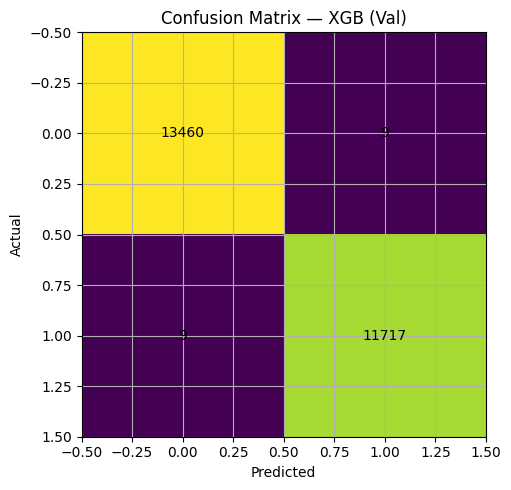

In [6]:

xgb = XGBClassifier(
    objective="binary:logistic",
    eval_metric="logloss",
    n_estimators=300,
    random_state=42,
    n_jobs=-1,
    tree_method="hist"  # fast & memory efficient
)

xgb_pipe = ImbPipeline(steps=[
    ("preprocess", preprocessor),
    ("smote", smote),
    ("clf", xgb)
])

param_grid = {
    "clf__max_depth": [4, 6, 8],
    "clf__learning_rate": [0.05, 0.1],
    "clf__subsample": [0.8, 1.0],
    "clf__colsample_bytree": [0.8, 1.0],
}

grid = GridSearchCV(
    xgb_pipe,
    param_grid=param_grid,
    scoring="f1",
    n_jobs=-1,
    cv=3,
    verbose=1
)

grid.fit(X_tr, y_tr)
print("Best Params:", grid.best_params_)
best_xgb = grid.best_estimator_

print("\nValidation Performance (Best XGB):")
xgb_val_metrics = evaluate_model(best_xgb, X_val, y_val, label="XGB (Val)")



## 7. Final Evaluation on Test Set


Baseline on Test Set:
=== Baseline (Test) ===
F1: 0.7460 | Precision: 0.9675 | Recall: 0.6070 | Accuracy: 0.7647 | FPR: 0.0270

Classification Report:
               precision    recall  f1-score   support

           0       0.65      0.97      0.78      9711
           1       0.97      0.61      0.75     12833

    accuracy                           0.76     22544
   macro avg       0.81      0.79      0.76     22544
weighted avg       0.83      0.76      0.76     22544



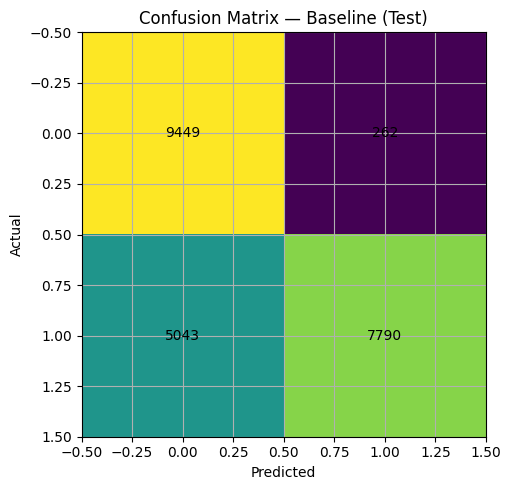


XGB on Test Set:
=== XGB (Test) ===
F1: 0.7792 | Precision: 0.9683 | Recall: 0.6519 | Accuracy: 0.7897 | FPR: 0.0282

Classification Report:
               precision    recall  f1-score   support

           0       0.68      0.97      0.80      9711
           1       0.97      0.65      0.78     12833

    accuracy                           0.79     22544
   macro avg       0.82      0.81      0.79     22544
weighted avg       0.84      0.79      0.79     22544



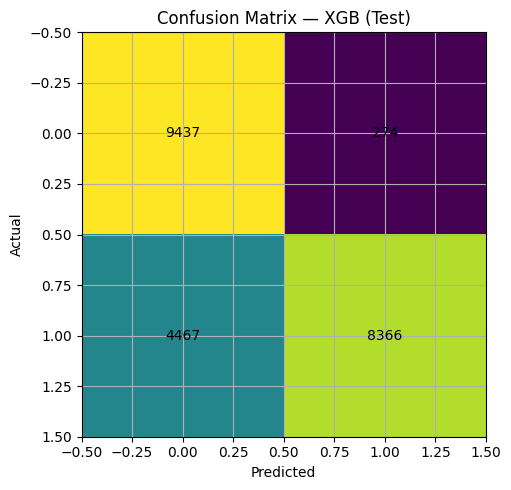

In [7]:

print("Baseline on Test Set:")
_ = evaluate_model(baseline_pipe, X_test_raw, y_test, label="Baseline (Test)")

print("\nXGB on Test Set:")
_ = evaluate_model(best_xgb, X_test_raw, y_test, label="XGB (Test)")



## 8. Model Interpretability with SHAP
We compute **SHAP values** for the best XGBoost model to explain which features drive predictions.
> Note: We compute SHAP on a sample for speed.


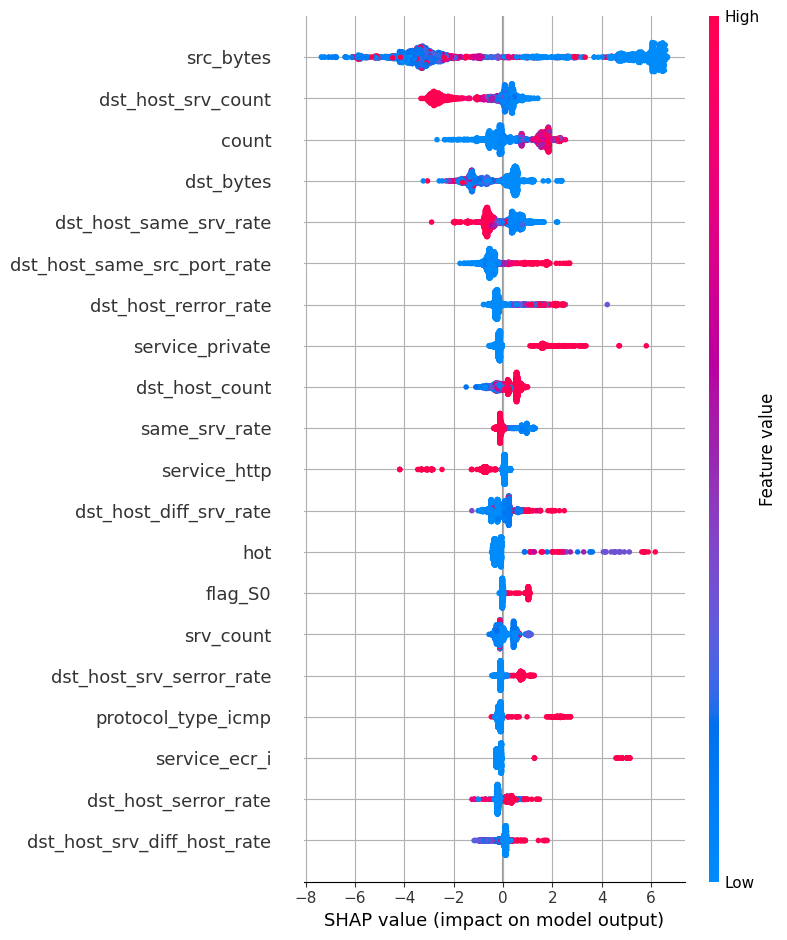

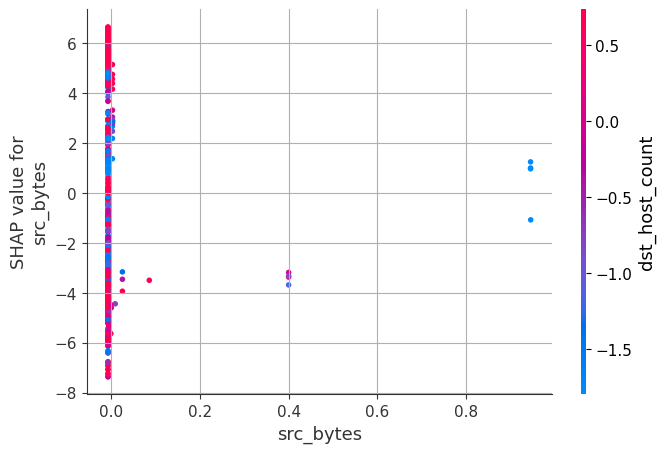

In [8]:

# Extract trained XGB model and the fitted preprocessor from the pipeline
fitted_preprocessor = best_xgb.named_steps["preprocess"]
fitted_clf = best_xgb.named_steps["clf"]

# Transform a sample of validation data to model-ready numeric features
sample_idx = np.random.RandomState(42).choice(len(X_val), size=min(2000, len(X_val)), replace=False)
X_val_sample = X_val.iloc[sample_idx]
y_val_sample = y_val.iloc[sample_idx]

X_val_transformed = fitted_preprocessor.transform(X_val_sample)

# Get feature names from the preprocessor
def get_feature_names(preprocessor, numeric_features, categorical_features):
    num_features_out = numeric_features
    cat_encoder = preprocessor.named_transformers_["cat"].named_steps["onehot"]
    cat_features_out = cat_encoder.get_feature_names_out(categorical_features).tolist()
    return num_features_out + cat_features_out

feature_names = get_feature_names(fitted_preprocessor, 
                                  fitted_preprocessor.transformers_[0][2], 
                                  fitted_preprocessor.transformers_[1][2])

# SHAP analysis
explainer = shap.TreeExplainer(fitted_clf)
shap_values = explainer.shap_values(X_val_transformed)

# Summary plot
shap.summary_plot(shap_values, X_val_transformed, feature_names=feature_names, show=True)
plt.show()

# Dependence plot for a top feature
top_feature_idx = np.argsort(np.abs(shap_values).mean(axis=0))[-1]
top_feature_name = feature_names[top_feature_idx]
shap.dependence_plot(top_feature_name, shap_values, X_val_transformed, feature_names=feature_names, show=True)
plt.show()



## 9. Ethical Analysis

- **Privacy:** Even anonymized network telemetry can reveal sensitive behavior. Use data minimization and access controls; avoid storing PII; follow GDPR-like principles where applicable.
- **False Positives:** High FPR can overwhelm analysts and cause alert fatigue. Balance precision/recall carefully; route low-confidence alerts to sandbox rather than block.
- **Bias & Coverage:** Rare attack types may be under-detected. Use techniques like **SMOTE**, targeted data augmentation, and periodic re-training on fresh telemetry.
- **Human-in-the-Loop:** Keep humans in decision loops for critical actions (blocking/quarantine). Provide explanations (e.g., **SHAP**) to support trust and oversight.



## 10. Conclusion & Future Work

**Summary:** We built an IDS on NSL-KDD with an XGBoost core, addressed class imbalance via SMOTE, and explained predictions using SHAP. We benchmarked against a Random Forest baseline and evaluated with F1, precision, recall, accuracy, and FPR.

**Future Enhancements:**
- Add MLflow for experiment tracking and reproducibility
- Evaluate deep learning or autoencoder-based anomaly detection
- Explore streaming inference and real-time features
- Perform feature drift and data quality monitoring in production



## 11. Export Trained Model
Save the trained XGBoost pipeline to disk for reuse in downstream applications.


In [9]:

OUTPUT_DIR = Path("./models")
OUTPUT_DIR.mkdir(parents=True, exist_ok=True)

model_path = OUTPUT_DIR / "xgb_nslkdd_pipeline.joblib"
joblib.dump(best_xgb, model_path)
print("Saved model to:", model_path.resolve())


Saved model to: C:\Users\user\OneDrive\Desktop\UG\L300\Sem-2\CPEN 316 (Artificial Intelligence and its Applications)\IDS-project\intrusion-detection-system\models\xgb_nslkdd_pipeline.joblib



## 12. Appendix: Model Spec & Config

```yaml
model:
  name: xgboost_classifier
  objective: binary:logistic
  metrics: [f1, precision, recall, accuracy, fpr]
  imbalance: SMOTE
  interpretability: SHAP
  selection: grid_search (cv=3)
  features:
    categorical: [protocol_type, service, flag]
    numerical: all_others
artifacts:
  pipeline: models/xgb_nslkdd_pipeline.joblib
  notebooks: this_notebook.ipynb
```
